In [276]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [277]:
df = pd.read_csv('../data/train.csv', index_col=0)
del df['BUTTER']
df.columns = df.columns.str.strip()

df.columns

Index(['B_OWNPV_CHI2', 'B_IPCHI2_OWNPV', 'B_FDCHI2_OWNPV', 'B_DIRA_OWNPV',
       'B_PT', 'Kst_892_0_IP_OWNPV', 'Kst_892_0_cosThetaH', 'Kplus_IP_OWNPV',
       'Kplus_P', 'piminus_IP_OWNPV', 'piminus_P', 'gamma_PT', 'piminus_ETA',
       'Kplus_ETA', 'signal'],
      dtype='object')

## Distribution plots for all variables

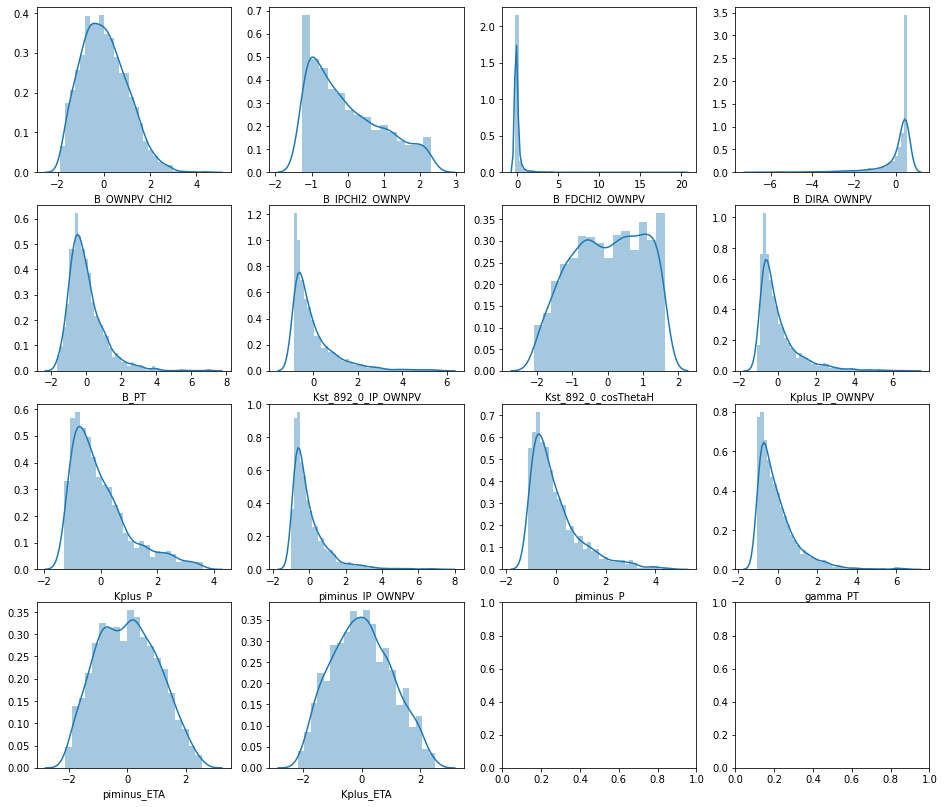

In [329]:
from sklearn.preprocessing import StandardScaler, Normalizer, QuantileTransformer, RobustScaler

# Scaled
dfs = pd.DataFrame(data=StandardScaler().fit_transform(df), columns=df.columns, index=df.index)
del dfs['signal']

fig, axes = plt.subplots(4,4, figsize=(16,14))
for i, col in enumerate(dfs.columns):
    sns.distplot(dfs[::100][col], ax=axes[i//4,i%4], label=col)

## Correlation Engineering

### EXP / Log functions

c:\bin\python3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\bin\python3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


B_OWNPV_CHI2;0.03874789334398773;0.014750964063851341;0.028647128089201817;0.022411826880832028
B_IPCHI2_OWNPV;0.23543566260810428;0.1401904853645225;0.20588640906049757;0.14543143464002156
B_FDCHI2_OWNPV;0.04519681692987222;0.03908083152682244;0.0015805931747495928;0.17895796705576006
	saved ARRCOS_B_FDCHI2_OWNPV
B_DIRA_OWNPV;0.18267623844984512;0.12336599600980683;0.23382862452159064;0.18279810361788829
	saved EXP_B_DIRA_OWNPV
	saved ARRCOS_B_DIRA_OWNPV
B_PT;0.13940991793650098;0.06458120989172111;0.00020196907367382225;0.10950329934124495
Kst_892_0_IP_OWNPV;0.2285927252235864;0.10833543340041332;0.0845169734524148;0.20411321783949998
Kst_892_0_cosThetaH;0.19831292062301584;0.25327219463876294;0.2645304948808516;0.1370349492291262
	saved LOG__Kst_892_0_cosThetaH
	saved EXP_Kst_892_0_cosThetaH
Kplus_IP_OWNPV;0.22375742212590247;0.11108882297374668;0.03124248374628585;0.2003128912654369
Kplus_P;0.1965917233541105;0.08656850954696027;0.12868951327544187;0.1266980058771728
piminus_IP_OWN

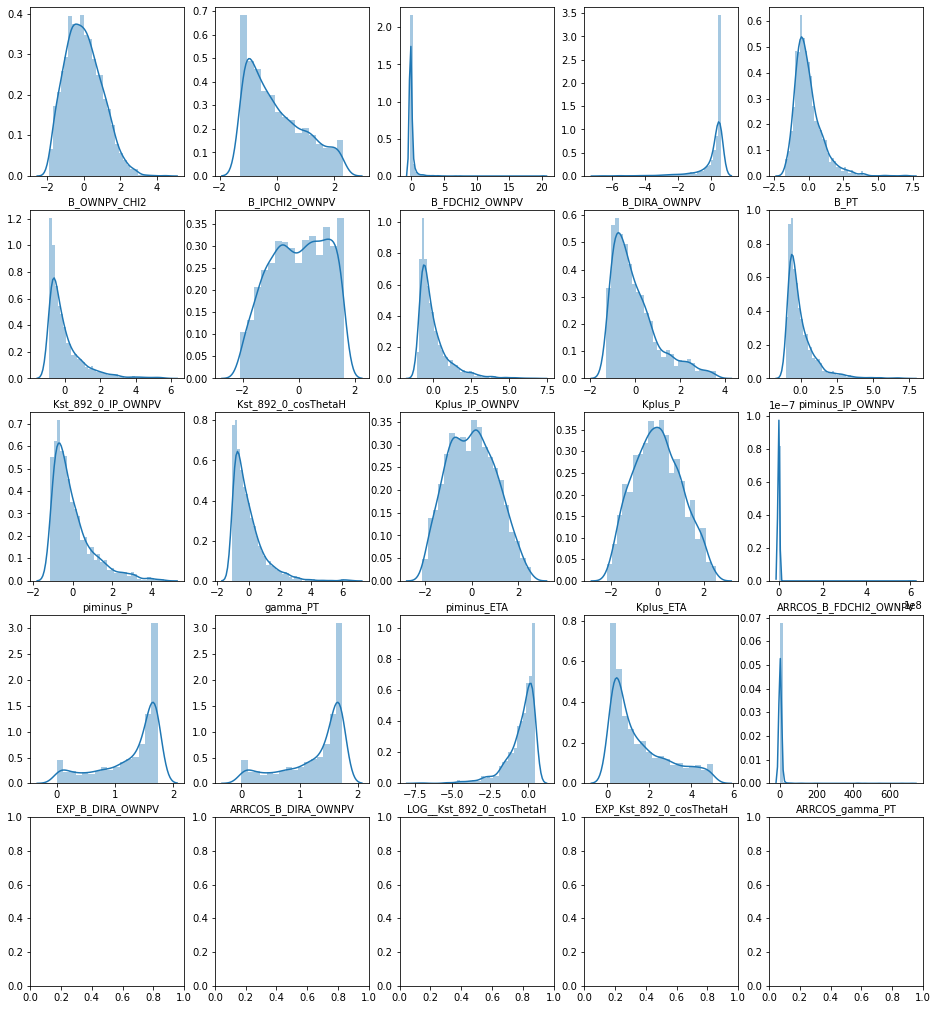

In [6]:
# For all cols, check if EXP / LOG improves correlation
dfs_op = dfs.copy(deep=False)

for col in dfs.columns:
    col_log = np.log(dfs[col])
    col_exp = np.exp(dfs[col])
    col_arccos = np.arccos(dfs[col])
    
    corr1 = dfs[col].corr(df.signal)
    corr2 = col_log.corr(df.signal)
    corr3 = col_exp.corr(df.signal)
    corr4 = col_arccos.corr(df.signal)
    corr1, corr2, corr3, corr4 = np.abs([corr1,corr2,corr3,corr4])
    
    print(col, corr1, corr2, corr3, corr4, sep=';')
   
    # Store best results
    if corr2 > corr1:
        dfs_op['LOG__'+col] = col_log
        print('\tsaved', 'LOG__'+col)
    if corr3 > corr1:
        dfs_op['EXP_'+col] = col_exp
        print('\tsaved', 'EXP_'+col)
    if corr4 > corr1:
        dfs_op['ARRCOS_'+col] = col_exp
        print('\tsaved', 'ARRCOS_'+col)
    
fig, axes = plt.subplots(5,5, figsize=(16,18))
for i, col in enumerate(dfs_op.columns):
    sns.distplot(dfs_op[::100][col], ax=axes[i//5,i%5], label=col)

### Multiply columns between themselves to find better correlations

In [331]:
df_in = dfs_op

correlations = []

for col in df_in.columns:
    if col == 'signal':
        continue
    corr = df_in[col].corr(df.signal)
    correlations += [(col, corr)]

for col1 in df_in.columns:
    for col2 in df_in.columns:
        cols = list(sorted([col1,col2]))
        colname = '__X__'.join(cols)
        if 'signal' in (col1, col2):
            continue
        
        corr = (df_in[col1] * df_in[col2]).corr(df.signal)
        correlations += [(colname, corr)]

# Create final correlation ranking scores
# Create a dict from the correlations to remove duplicates, and then order by the absolute value
correlations = list(reversed(sorted(correlations, key=lambda x:x[1])))
best_correlations = list(reversed(
    sorted(
        dict(correlations).items(), key=lambda x: abs(x[1])
    )
))
best_correlations[:15]

[('EXP_Kst_892_0_cosThetaH__X__LOG__Kst_892_0_cosThetaH', -0.3036668155600205),
 ('Kst_892_0_cosThetaH__X__LOG__Kst_892_0_cosThetaH', -0.30074619672317954),
 ('EXP_Kst_892_0_cosThetaH__X__Kst_892_0_cosThetaH', -0.2761145652531395),
 ('EXP_B_DIRA_OWNPV__X__LOG__Kst_892_0_cosThetaH', -0.2744812136600346),
 ('EXP_Kst_892_0_cosThetaH__X__EXP_Kst_892_0_cosThetaH', -0.27143605327180764),
 ('EXP_Kst_892_0_cosThetaH', -0.2645304948808516),
 ('LOG__Kst_892_0_cosThetaH', -0.25327219463876294),
 ('EXP_B_DIRA_OWNPV__X__EXP_B_DIRA_OWNPV', 0.2449750424603403),
 ('B_DIRA_OWNPV__X__EXP_B_DIRA_OWNPV', 0.24093470199627245),
 ('B_IPCHI2_OWNPV', -0.23543566260810428),
 ('EXP_B_DIRA_OWNPV', 0.23382862452159064),
 ('Kst_892_0_IP_OWNPV', 0.2285927252235864),
 ('B_IPCHI2_OWNPV__X__EXP_B_DIRA_OWNPV', -0.2255139752132278),
 ('Kplus_IP_OWNPV', 0.22375742212590247),
 ('piminus_IP_OWNPV', 0.2102318935898559)]

In [334]:
df_in = dfs_op

df_corr = df_in.copy(deep=False)

for col, _ in best_correlations[:15]:
    if '__X__' not in col:
        continue
    col1, col2 = col.split('__X__')
    df_corr[col] = df_in[col1] * df_in[col2]
    
df_corr.shape, df_corr.dropna(how="any").shape

((212662, 25), (109590, 25))

## Pairplot with all new features

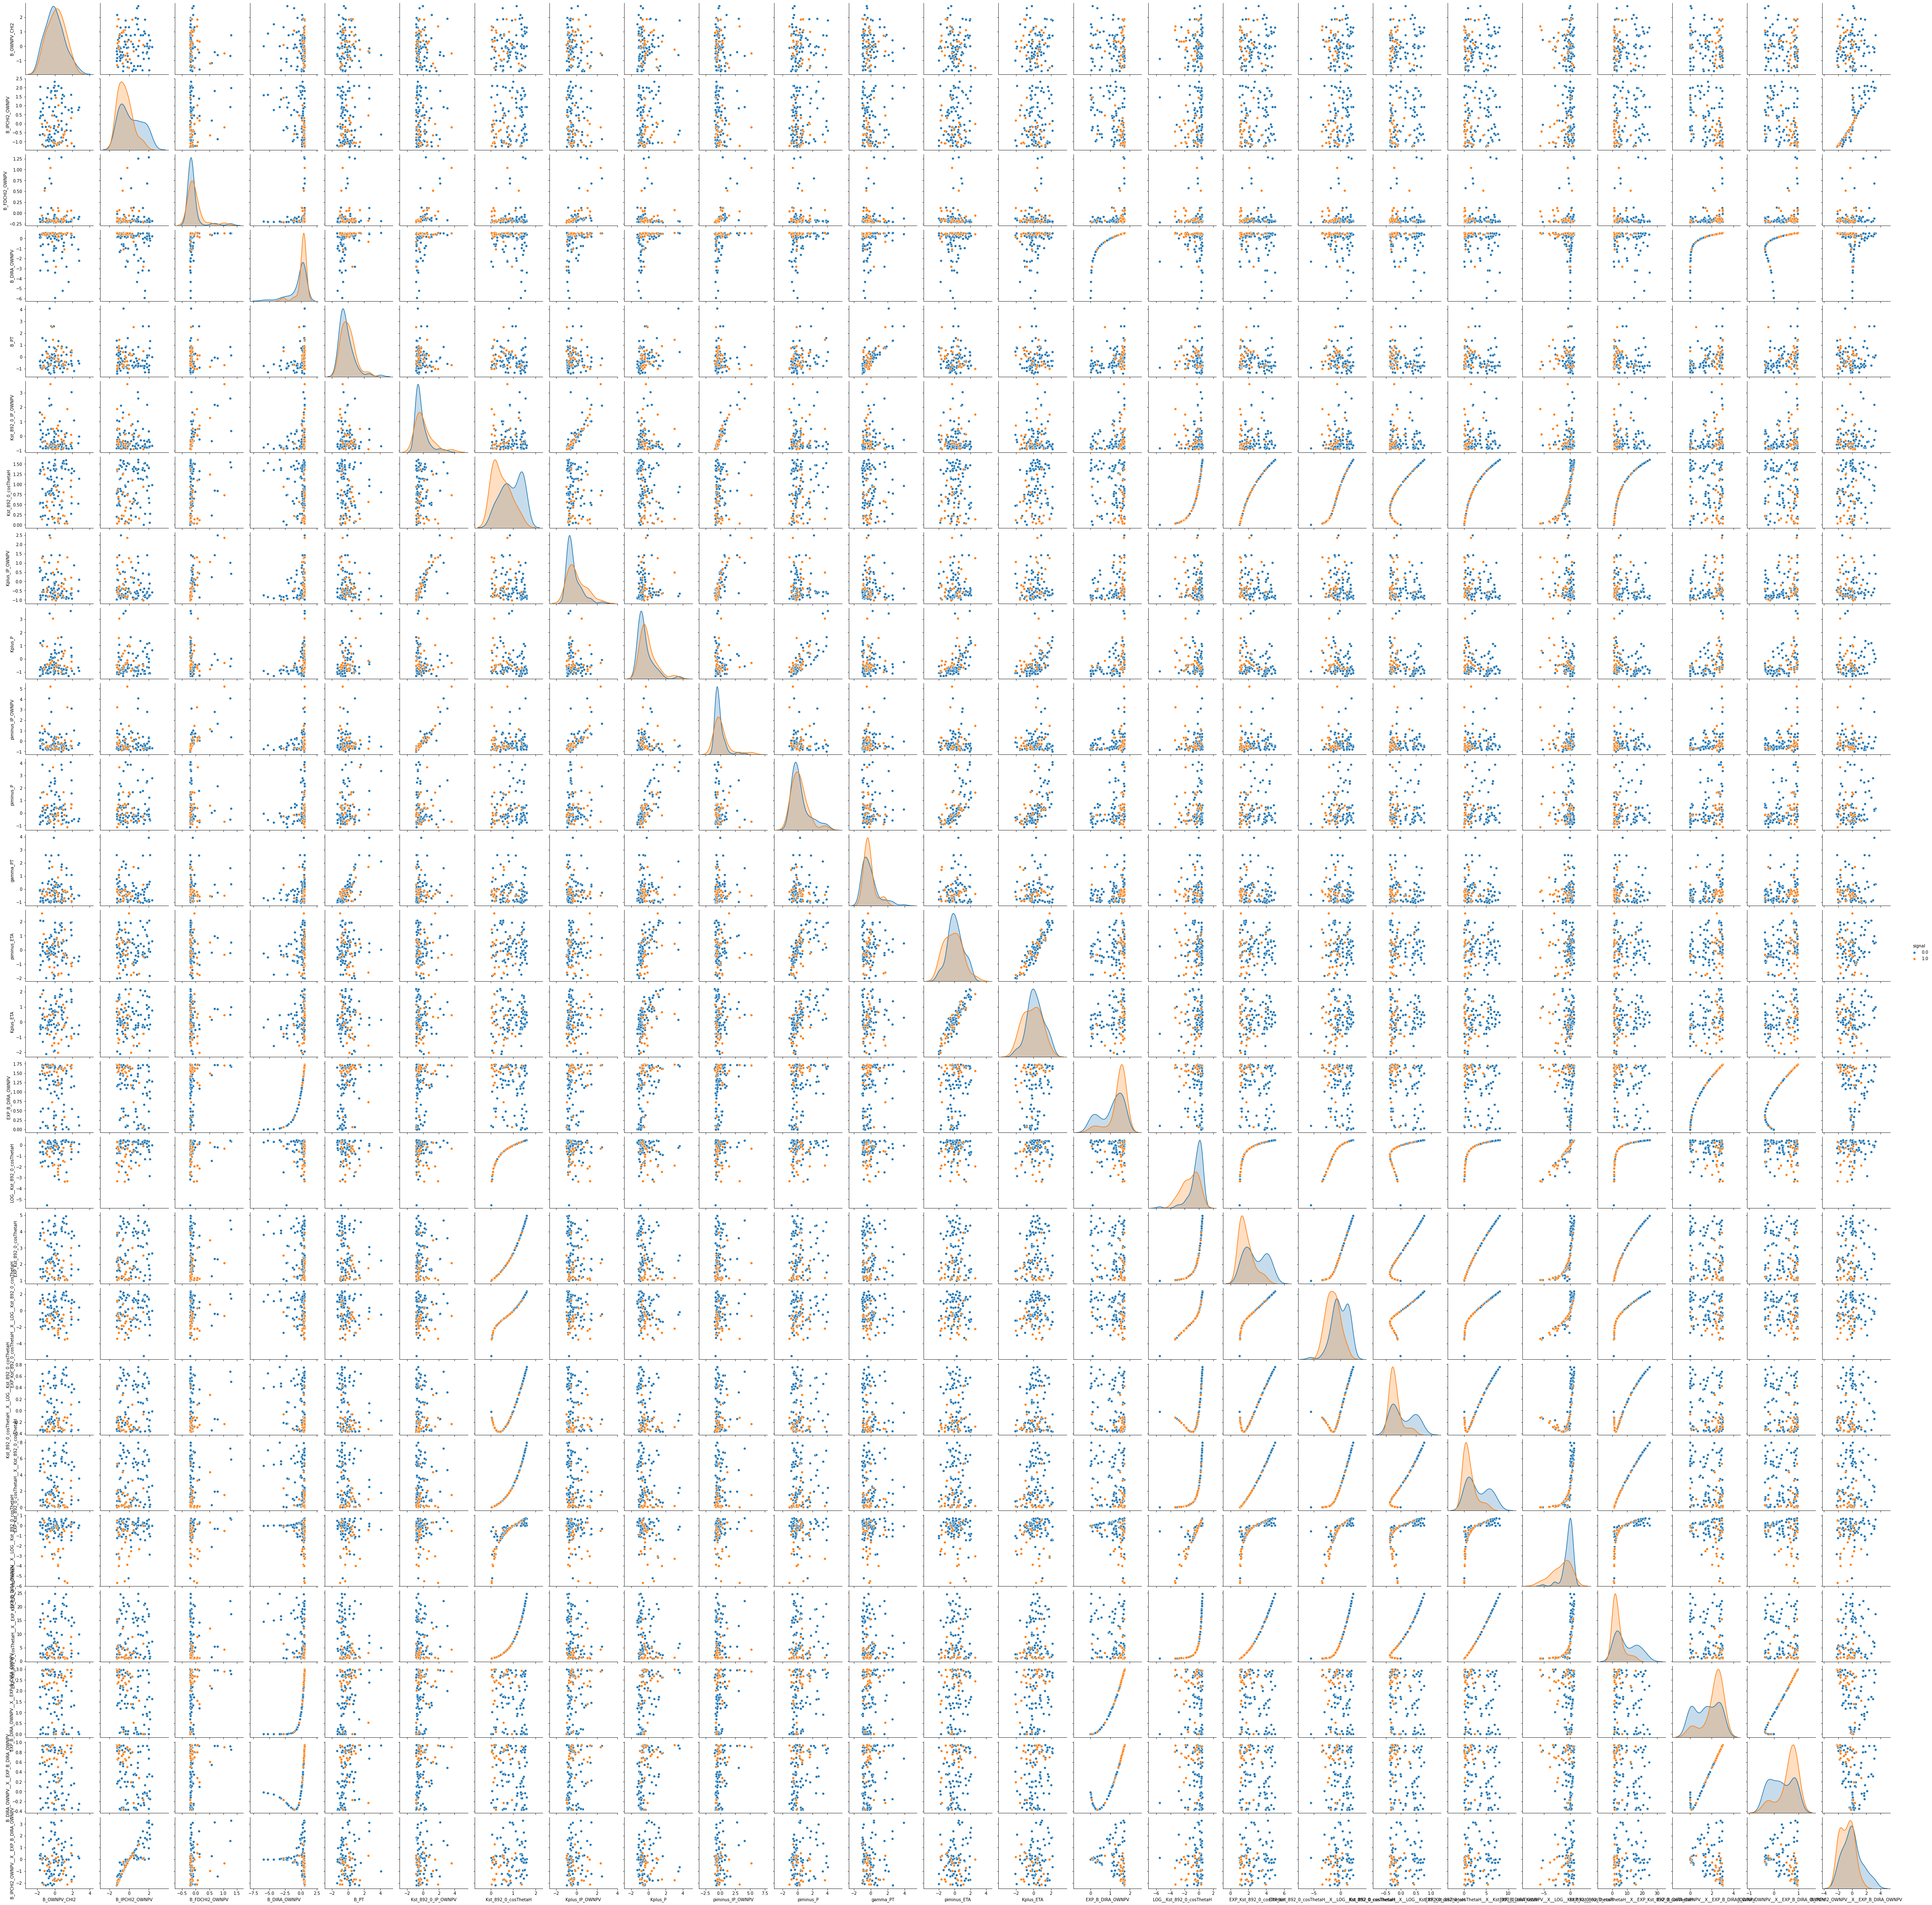

In [344]:
df_pairplot = pd.concat([df_corr, df[['signal']]], axis=1)
sns.pairplot(df_pairplot.dropna()[::1000], hue='signal')

## Test model with best correlations

In [336]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, KFold

# data in
data = dfs_op.fillna(dfs_op.mean())

# Data
X = data
y = df.signal

# Model and Scaler Parameters
model = RandomForestClassifier(class_weight={0: 2, 1: 3}, min_samples_leaf=5)
scaler = RobustScaler()

# KFold 5 way cross validation
n_splits = 8
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=0)

acc = 0
roc = 0

for i, (train, test) in enumerate(kfold.split(X, y)):
    print('Validating... %d of %d' % (i+1, n_splits))
    if i > 0:
        print('\tACC so far: ', acc / i * n_splits )
        print('\tROC so far: ', roc / i * n_splits )
    
    X_train, y_train = X.iloc[train], y.iloc[train]
    X_test, y_test = X.iloc[test], y.iloc[test]
    
    X_train = scaler.fit_transform(X_train)
    model.fit(X_train, y_train)
    
    X_test = scaler.transform(X_test)
    y_hat = model.predict(X_test)
    y_hat_prob = model.predict_proba(X_test)[:,1]
    
    acc += accuracy_score(y_test, y_hat) / kfold.get_n_splits()
    roc += roc_auc_score(y_test, y_hat_prob) / kfold.get_n_splits()

print("Accuracy Score:\t %.5f" % acc)
print("ROC Score:\t %.5f" % roc)

Validating... 1 of 8
Validating... 2 of 8
	ACC so far:  0.7728999736673814
	ROC so far:  0.8386553574481741


KeyboardInterrupt: 

Accuracy Score:	 0.79151
ROC Score:	 0.84520
